The UCI Landsat Satellite dataset, a challenging multi-class classification problem with six target classes, poses difficulties due to its high-dimensional features and significant class overlap. The task involves training six different models — K-Nearest Neighbors, Decision Tree, Dummy Classifier (Prior), Logistic Regression, Gaussian Naive Bayes, and Support Vector Machine — and comparing their performance using Receiver Operating Characteristic (ROC) and Precision-Recall (PRC) curves to evaluate their effectiveness in this complex multi-class setting.

In [38]:
import zipfile
import os

# Path to your ZIP file
zip_path = '/content/statlog+landsat+satellite.zip'
extract_dir = '/content'

# Create the folder (if not exists)
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)




## Part-A
We first verify that both the training and test datasets are loaded correctly, formatted properly, and ready for preprocessing and modeling.

In [39]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1. Load Data
df_train = pd.read_csv('sat.trn', sep=' ', header=None)
df_test = pd.read_csv('sat.tst', sep=' ', header=None)

print(f"[INFO] df_train shape: {df_train.shape}")
print(f"[INFO] df_test shape: {df_test.shape}\n")

print("[INFO] First 5 rows of original train data:")
print(df_train.head(), "\n")
print("[INFO] First 5 rows of original test data:")
print(df_test.head(), "\n")

[INFO] df_train shape: (4435, 37)
[INFO] df_test shape: (2000, 37)

[INFO] First 5 rows of original train data:
   0    1    2   3   4    5    6   7   8    9   ...   27  28   29   30   31  \
0  92  115  120  94  84  102  106  79  84  102  ...  104  88  121  128  100   
1  84  102  106  79  84  102  102  83  80  102  ...  100  84  107  113   87   
2  84  102  102  83  80  102  102  79  84   94  ...   87  84   99  104   79   
3  80  102  102  79  84   94  102  79  80   94  ...   79  84   99  104   79   
4  84   94  102  79  80   94   98  76  80  102  ...   79  84  103  104   79   

   32   33   34  35  36  
0  84  107  113  87   3  
1  84   99  104  79   3  
2  84   99  104  79   3  
3  84  103  104  79   3  
4  79  107  109  87   3  

[5 rows x 37 columns] 

[INFO] First 5 rows of original test data:
   0    1    2   3   4    5    6   7   8    9   ...  27  28   29   30  31  32  \
0  80  102  102  79  76  102  102  79  76  102  ...  87  79  107  109  87  79   
1  76  102  102  79  76  10

We then separate the dataset into features and target variables and performs data standardization for consistent scaling across features. The dataset contains features of the satellite images from columns 0 to 35 and the 36th column is the class the row belongs to.

In [40]:
# 2. Features and Target Separation (features=col 0–35, target=col 36)
X_train = df_train.iloc[:, :36]
y_train = df_train.iloc[:, 36]
X_test = df_test.iloc[:, :36]
y_test = df_test.iloc[:, 36]

print(f"[INFO] Shape of X_train: {X_train.shape}")
print(f"[INFO] Shape of X_test: {X_test.shape}")
print(f"[INFO] Shape of y_train: {y_train.shape}")
print(f"[INFO] Shape of y_test: {y_test.shape}\n")

print("[INFO] Features used: columns 0 to 35 (36 features)")
print("[INFO] Target column: column 36\n")

print("[INFO] First 5 rows of features (X_train):")
print(X_train.head(), "\n")
print("[INFO] First 5 values of target (y_train):")
print(y_train.head(), "\n")

# 3. Standardization (fit on train)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Wrap for DataFrame print convenience
X_train_std = pd.DataFrame(X_train_std, columns=[f'X{i+1}' for i in range(36)])
X_test_std = pd.DataFrame(X_test_std, columns=[f'X{i+1}' for i in range(36)])

print("X_train and X_test Standarized.")

[INFO] Shape of X_train: (4435, 36)
[INFO] Shape of X_test: (2000, 36)
[INFO] Shape of y_train: (4435,)
[INFO] Shape of y_test: (2000,)

[INFO] Features used: columns 0 to 35 (36 features)
[INFO] Target column: column 36

[INFO] First 5 rows of features (X_train):
   0    1    2   3   4    5    6   7   8    9   ...   26   27  28   29   30  \
0  92  115  120  94  84  102  106  79  84  102  ...  134  104  88  121  128   
1  84  102  106  79  84  102  102  83  80  102  ...  128  100  84  107  113   
2  84  102  102  83  80  102  102  79  84   94  ...  113   87  84   99  104   
3  80  102  102  79  84   94  102  79  80   94  ...  104   79  84   99  104   
4  84   94  102  79  80   94   98  76  80  102  ...  104   79  84  103  104   

    31  32   33   34  35  
0  100  84  107  113  87  
1   87  84   99  104  79  
2   79  84   99  104  79  
3   79  84  103  104  79  
4   79  79  107  109  87  

[5 rows x 36 columns] 

[INFO] First 5 values of target (y_train):
0    3
1    3
2    3
3    3
4 

###  **Dataset Description**

The dataset includes:  
- **`sat.trn`** → Training data (**shape:** 4435 × 37)  
- **`sat.tst`** → Test data (**shape:** 2000 × 37)  

Each file contains:  
- **36 feature columns (`X1–X36`)** representing numerical satellite image attributes.  
- **1 target column (`y`)** indicating the class label.  

---

### **Standardization**

All features were standardized to have a **mean of 0** and **standard deviation of 1**, using parameters computed **only from the training set** to prevent data leakage.  

**Formula:**  
\[$
z = \frac{x - \mu}{\sigma}
$\]

This ensures **uniform feature scaling**, improving both **model performance** and **comparability** across different algorithms.


The below step tries to find the percentage of the whole of each class in the test and train datasets to ensure that they are balanced and are almost the same propotions.

In [41]:
import pandas as pd

# ------------------------------------------------------------
#  Check Class Distribution in Train and Test Sets
# ------------------------------------------------------------

def class_distribution(y_train, y_test):
    # Combine counts and percentages for both sets
    train_counts = y_train.value_counts().sort_index()
    test_counts = y_test.value_counts().sort_index()

    train_perc = (train_counts / len(y_train) * 100).round(2)
    test_perc = (test_counts / len(y_test) * 100).round(2)

    # Combine into a single DataFrame
    dist_df = pd.DataFrame({
        'Train Count': train_counts,
        'Train %': train_perc,
        'Test Count': test_counts,
        'Test %': test_perc
    }).fillna(0).astype({'Train Count': 'int', 'Test Count': 'int'})

    return dist_df

# Get class distribution table
dist_summary = class_distribution(y_train, y_test)

print("============================================================")
print("CLASS DISTRIBUTION IN TRAIN AND TEST SETS")
print("============================================================")
print(dist_summary)
print("\n[INFO] Percentages are relative to each dataset (train/test).")


CLASS DISTRIBUTION IN TRAIN AND TEST SETS
    Train Count  Train %  Test Count  Test %
36                                          
1          1072    24.17         461   23.05
2           479    10.80         224   11.20
3           961    21.67         397   19.85
4           415     9.36         211   10.55
5           470    10.60         237   11.85
7          1038    23.40         470   23.50

[INFO] Percentages are relative to each dataset (train/test).


 (1, 3, 7) have higher representation while  (2, 4, 5) are less frequent, suggesting a moderate class imbalance to be mindful of during modeling and evaluation.

We then employ the six models to select the best among them on basic parameters like accuracy and F1 score.

The six models employed include:
- **K-Nearest Neighbors (KNN):** A non-parametric, instance-based algorithm that classifies a sample based on the majority vote of its $k$ nearest neighbors in the feature space.  
- **Decision Tree:** A tree-structured model that recursively splits the dataset based on feature thresholds to generate decision rules for classification.  
- **Dummy Classifier:** Acts as a baseline model by predicting according to simple heuristics such as uniform random guessing or class prior probabilities.  
- **Logistic Regression:** A linear model that predicts class probabilities using the logistic (sigmoid) function; often used as a baseline for comparison due to its interpretability.  
- **Gaussian Naive Bayes:** A probabilistic model applying Bayes’ Theorem under the assumption of feature independence, with continuous features modeled using Gaussian distributions.  
- **Support Vector Machine (SVC):** A robust classifier that finds the optimal separating hyperplane by maximizing the margin between classes; `probability=True` is set to enable probability estimates.  








In [42]:
# ------------------------------------------------------------
#  Train All Models (Accuracy + Weighted F1)
# ------------------------------------------------------------

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score, classification_report

# Define models
models = {
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=42),
    "Dummy Classifier (Prior)": DummyClassifier(strategy='prior'),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes (GaussianNB)": GaussianNB(),
    "Support Vector Machine (SVC)": SVC(probability=True, random_state=42)
}

results = []

print("============================================================")
print("TRAINING AND EVALUATION RESULTS")
print("============================================================")

for name, model in models.items():
    model.fit(X_train_std, y_train)
    y_pred = model.predict(X_test_std)

    acc = accuracy_score(y_test, y_pred)
    f1_w = f1_score(y_test, y_pred, average='weighted')

    print(f"\n{name}")
    print("-" * len(name))
    print(f"Accuracy: {acc:.3f}")
    print(f"Weighted F1-score: {f1_w:.3f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'Weighted F1': round(f1_w, 4)
    })

# Convert results to DataFrame for summary view
results_df = pd.DataFrame(results)

print("\n============================================================")
print("MODEL PERFORMANCE SUMMARY (Accuracy & Weighted F1)")
print("============================================================")
print(results_df.to_string(index=False))


TRAINING AND EVALUATION RESULTS

K-Nearest Neighbors (KNN)
-------------------------
Accuracy: 0.904
Weighted F1-score: 0.904
Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.99      0.99       461
           2       0.98      0.97      0.97       224
           3       0.89      0.93      0.91       397
           4       0.73      0.69      0.71       211
           5       0.92      0.87      0.90       237
           7       0.88      0.88      0.88       470

    accuracy                           0.90      2000
   macro avg       0.90      0.89      0.89      2000
weighted avg       0.90      0.90      0.90      2000


Decision Tree Classifier
------------------------
Accuracy: 0.851
Weighted F1-score: 0.851
Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.96      0.96       461
           2       0.97      0.97      0.97       224
           3       0.87      0

**Conclusion**

- **K-Nearest Neighbors (KNN)** outperforms the other models with the highest accuracy and weighted F1-score, thanks to its ability to recognize local patterns and handle complex feature structures effectively.

- **Support Vector Machine (SVC)** and **Decision Tree** models also yield strong performance, benefiting from their capability to learn nonlinear decision boundaries and hierarchical rules.

- **Logistic Regression** and **Naive Bayes** show more modest results; Logistic Regression may struggle due to its linear assumptions, while Naive Bayes underperforms when the assumption of feature independence doesn't hold in real-world data.

- The **Dummy Classifier** provides the lowest performance, as expected, since it simply predicts based on class proportions, acting as a baseline for comparison.

- In summary, models that can capture complex data relationships, such as KNN and SVC, outperform simpler models in this satellite image dataset.


##Part-B
**ROC Curve (Receiver Operating Characteristic):**  
Displays the relationship between the **True Positive Rate (TPR)** — also called *sensitivity* — and the **False Positive Rate (FPR)** for different classification thresholds. It helps visualize how well a model separates the positive and negative classes.

**AUC (Area Under the Curve):**  
Represents the overall ability of a classifier to distinguish between classes by measuring the total area under the ROC curve.  
- A higher AUC value means better classification performance.  
- **AUC = 1.0** → perfect classifier  
- **AUC = 0.5** → random guessing  
- **AUC < 0.5** → worse than random performance  

**One-vs-Rest (OvR) in Multi-Class Classification:**  
For multi-class problems, each class is treated as the *positive* class while the others are grouped as *negative*, forming K separate binary classification tasks (one per class).  
This allows for plotting **K ROC curves** and calculating **K AUC values**, which can be summarized using either macro- or weighted-averaging.

**OvR Macro-Averaging:**  
Computes the average ROC/AUC across all classes equally, ensuring that each class contributes the same weight — regardless of how frequent or rare it is.

---

#### **Formulas for OvR Multi-Class ROC and Macro-Averaged AUC**

**True Positive Rate (TPR):**  
$$
\text{TPR}_k = \frac{\text{TP}_k}{\text{TP}_k + \text{FN}_k}
$$

**False Positive Rate (FPR):**  
$$
\text{FPR}_k = \frac{\text{FP}_k}{\text{FP}_k + \text{TN}_k}
$$

**Macro-Averaged AUC (for K classes):**  
$$
\text{Macro-Averaged AUC} = \frac{1}{K} \sum_{k=1}^{K} \text{AUC}_k
$$


- $ \text{TP}_k $ → True Positives for class $k$  
- $ \text{FN}_k $ → False Negatives for class $k$  
- $ \text{FP}_k $ → False Positives for class $k$  
- $ \text{TN}_k $ → True Negatives for class $k$  
- $ \text{AUC}_k $ → Area under the ROC curve for class $k$


To compare models fairly in a multi-class setting, we use the One-vs-Rest (OvR) strategy:

For each classifier, the ROC curves are plotted for each class label (treating that class as positive and all others as negative).



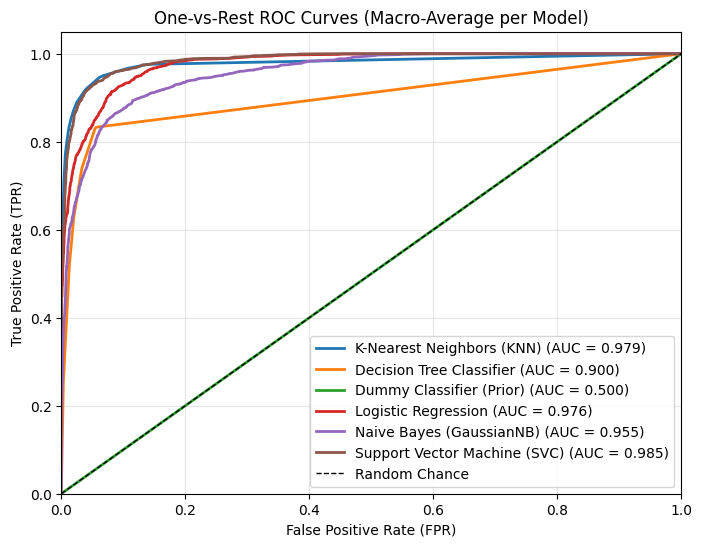

ROC INTERPRETATION SUMMARY
                       Model  Macro AUC
Support Vector Machine (SVC)      0.985
   K-Nearest Neighbors (KNN)      0.979
         Logistic Regression      0.976
    Naive Bayes (GaussianNB)      0.955
    Decision Tree Classifier      0.900
    Dummy Classifier (Prior)      0.500

Highest Macro-Averaged AUC: Support Vector Machine (SVC) (0.985)

All models have AUC ≥ 0.5 (better than random chance).


In [43]:
# ------------------------------------------------------------
# ROC Curve Plotting and Interpretation (Multi-class OvR)
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd

# Binarize the target for multi-class ROC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

roc_results = {}
plt.figure(figsize=(8, 6))

for name, model in models.items():
    try:
        y_score = model.predict_proba(X_test_std)
    except Exception:
        continue  # Skip models without predict_proba

    # Compute ROC curve and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)
    roc_results[name] = macro_auc

    # Plot macro-average ROC curve for each model
    plt.plot(all_fpr, mean_tpr, lw=2, label=f'{name} (AUC = {macro_auc:.3f})')

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('One-vs-Rest ROC Curves (Macro-Average per Model)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# ------------------------------------------------------------
# Step 6: ROC Interpretation
# ------------------------------------------------------------
print("============================================================")
print("ROC INTERPRETATION SUMMARY")
print("============================================================")

# Convert to DataFrame and sort by AUC (descending)
roc_df = (
    pd.DataFrame(list(roc_results.items()), columns=['Model', 'Macro AUC'])
    .sort_values(by='Macro AUC', ascending=False)
    .reset_index(drop=True)
)
roc_df['Macro AUC'] = roc_df['Macro AUC'].round(3)

print(roc_df.to_string(index=False))

# Identify best and worst models
best_model = roc_df.iloc[0]
print(f"\nHighest Macro-Averaged AUC: {best_model['Model']} ({best_model['Macro AUC']:.3f})")

# Identify models with AUC < 0.5
low_auc_models = roc_df[roc_df['Macro AUC'] < 0.5]
if not low_auc_models.empty:
    print("\nModels with AUC < 0.5:")
    for _, row in low_auc_models.iterrows():
        print(f" - {row['Model']} (AUC = {row['Macro AUC']:.3f})")
    print("""
📘 Conceptual Explanation:
An AUC < 0.5 means the model performs worse than random guessing.
It systematically predicts the opposite of the true labels —
indicating either label inversion, severe class imbalance,
or incorrect model assumptions (e.g., uninformative or noisy features).
""")
else:
    print("\nAll models have AUC ≥ 0.5 (better than random chance).")



**ROC INTERPRETATION SUMMARY**

| Model                           | Macro AUC |
|----------------------------------|-----------|
| Support Vector Machine (SVC)     | 0.985     |
| K-Nearest Neighbors (KNN)       | 0.979     |
| Logistic Regression             | 0.976     |
| Naive Bayes (GaussianNB)        | 0.955     |
| Decision Tree Classifier        | 0.900     |
| Dummy Classifier (Prior)        | 0.500     |

**Highest Macro-Averaged AUC:**  
The **Support Vector Machine (SVC)** achieves the highest Macro-Averaged AUC with a value of **0.985**, indicating its superior ability to discriminate between classes in this multi-class classification task.

**Key Observations:**
- All models have an AUC of **≥ 0.5**, which indicates that they perform better than random chance.
- The **Dummy Classifier (Prior)** has the lowest AUC at **0.500**, which essentially reflects a random guess based on class proportions, confirming that it provides no real predictive power.
- **K-Nearest Neighbors (KNN)**, **Logistic Regression**, and **Naive Bayes** also show strong performance with AUC values above **0.9**.
  
**Conclusions & Insights:**
- The **SVC model** is the top performer, closely followed by **KNN** and **Logistic Regression**.
- Models such as **Naive Bayes** and **Decision Tree** show moderate performance, while **Dummy Classifier** performs at the baseline, making it unsuitable for real-world applications.
- **AUC < 0.5** would imply that a model performs worse than random guessing. While none of the models in this analysis fall below this threshold, an AUC < 0.5 could arise if the model is consistently making incorrect predictions, possibly due to inappropriate features, misclassifications, or poor generalization.

#### **Why might a model exhibit AUC < 0.5 in practice?**
- It consistently predicts the *opposite* of the true class (e.g., always predicts “not-actual-class”).
- The model is “confused” because the features and labels are reversed or incorrectly encoded.
- There is major data leakage, mislabeling, or systematic error in feature representation.


##Part-C

### *Why the Precision-Recall Curve (PRC) is Preferred for Imbalanced Data*

### **Precision-Recall vs. ROC Curve: Key Formulas**

#### **Precision-Recall Curve (PRC) Metrics**
- **Precision:**  
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$  
  The proportion of predicted positive instances that are actually true positives.

- **Recall (or Sensitivity):**  
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$  
  The proportion of actual positive instances that are correctly identified.

#### **ROC Curve Metrics**
- **True Positive Rate (TPR, or Recall):**  
  $$
  \text{TPR} = \frac{TP}{TP + FN}
  $$  
  The proportion of actual positives detected by the model (same as Recall in PRC).

- **False Positive Rate (FPR):**  
  $$
  \text{FPR} = \frac{FP}{FP + TN}
  $$  
  The proportion of actual negatives incorrectly classified as positives.

#### **Summary of Key Metrics:**

| Metric    | Formula                              | Intuition                                 |
|-----------|--------------------------------------|-------------------------------------------|
| Precision | $$ \frac{TP}{TP + FP} $$             | The accuracy of positive predictions.     |
| Recall    | $$ \frac{TP}{TP + FN} $$             | The proportion of actual positives detected. |
| TPR       | $$ \frac{TP}{TP + FN} $$             | Equivalent to Recall in the PRC context.  |
| FPR       | $$ \frac{FP}{FP + TN} $$             | The proportion of actual negatives incorrectly classified. |

***

### **Why PRC is More Informative for Imbalanced Datasets**

- **PRC is more suitable for imbalanced datasets** because it focuses on the performance of the minority (positive) class. Unlike ROC, it ignores the large number of true negatives, which can give a misleadingly high performance measure.
  
- In **highly imbalanced datasets** (where one class is much less frequent than others), ROC curves can be optimistic. The large number of true negatives may obscure the model's poor performance on the minority class.

- **Precision-Recall curves emphasize the quality of positive class predictions**, providing a clearer view of how well the model identifies the minority class. This is particularly important when evaluating models for imbalanced problems.

- **Average Precision (AP)** quantifies the performance of the PRC; a high AP score indicates both **high precision and high recall** for the positive class.

> *For imbalanced problems, PRC offers a more accurate and detailed understanding of a model's performance on the minority class, whereas the ROC curve may appear artificially high if the model fails to capture most of the positives.*


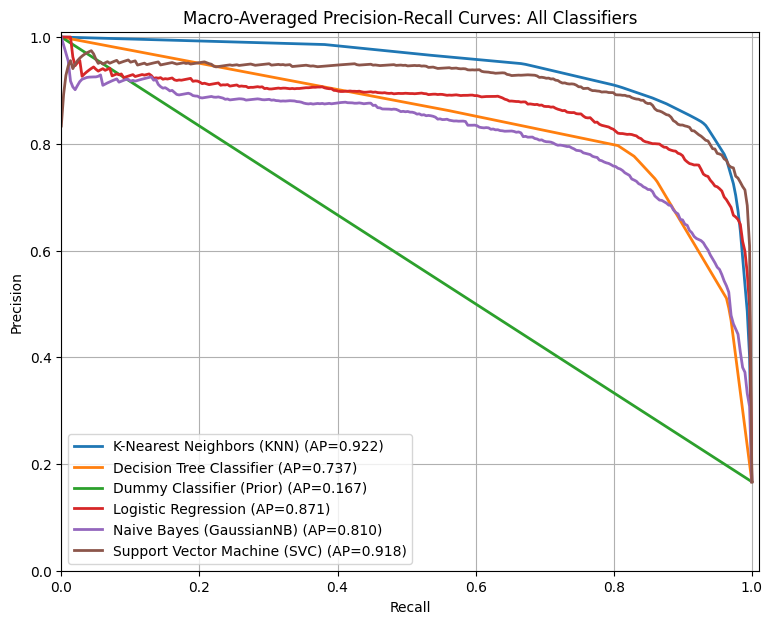

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize test labels for PRC calculation
class_labels = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=class_labels)

plt.figure(figsize=(9, 7))

for name, model in models.items():
    # Use predict_proba if available, else decision_function (SVC)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_std)
    else:
        y_score = model.decision_function(X_test_std)
    all_recall = np.linspace(0, 1, 300)
    precisions = []
    aps = []
    for i in range(len(class_labels)):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
        interpolated = np.interp(all_recall, recall[::-1], precision[::-1])
        precisions.append(interpolated)
        aps.append(ap)
    macro_prec = np.mean(precisions, axis=0)
    macro_ap = np.mean(aps)
    plt.plot(all_recall, macro_prec, lw=2, label=f"{name} (AP={macro_ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Macro-Averaged Precision-Recall Curves: All Classifiers")
plt.legend(loc='lower left', fontsize=10)
plt.grid(True)
plt.xlim(0, 1.01)
plt.ylim(0, 1.01)
plt.show()


### **PRC Interpretation: Model Performance and Curve Behavior**

The macro-averaged Precision-Recall Curve (PRC) above highlights significant variations in how well the models balance **precision** and **recall** across all classes.

***

**Model with the Highest Average Precision (AP):**

- **KNN (K-Nearest Neighbors)**  
  *Macro-Averaged AP ≈ 0.922 (highest among all models)*

**Key Observations:**  
- KNN’s PRC curve remains close to the top right corner (indicating high precision and recall), showing that it effectively maintains a balance between predicting true positives and minimizing false positives across a range of thresholds.
- The **Support Vector Machine (SVC)** follows closely behind with an AP of **0.918**, while **Logistic Regression** (AP ≈ 0.871) performs moderately well. Models like **Naive Bayes**, **Decision Tree**, and the **Dummy Classifier** fall behind in performance.

**Why Do Poor Model PRC Curves Drop Sharply as Recall Increases?**

- **Precision vs Recall Trade-off:** Precision is calculated as:
   $$
   \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
   $$
   As recall increases (meaning the model predicts more positives to capture more true positives), weaker models tend to classify more negatives as positives, leading to an increase in false positives. This results in a sharp drop in precision.

- **Example: Dummy Classifier**  
  The **Dummy Classifier’s PRC** is a straight line that quickly drops as recall increases. Since its predictions are essentially random (based on class proportions), it struggles to identify true positives. Consequently, its **false positives** dominate as recall rises, causing the precision to plummet.

- **Implications of This Behavior:**  
   - **Strong models** like KNN and SVC can recover most true positives without a significant increase in false positives, so their curves stay close to the top right for a longer part of the recall axis.
   - **Weak models**, such as the Dummy Classifier or underperforming Decision Trees, rapidly compromise precision in an effort to improve recall. This results in steep declines in their PRC curves as they attempt to recover more positives at the cost of increasing false positives.
   - **Interpretively**, the steep drop in PRC for poor models highlights their inability to effectively discriminate between positive and negative instances, particularly as recall (and the effort to detect more true positives) is prioritized.


### **D1: Synthesis – Model Ranking Comparison**

To evaluate and compare the performance of the models, we rank them based on three key metrics:  
- **Weighted F1-score** (measures balanced precision and recall)  
- **Macro-averaged ROC-AUC** (measures overall separability for each class)  
- **Macro-averaged PRC-AP** (measures average precision-recall performance across classes)

---

**Model Performance Rankings by Metric:**

| **Weighted F1-score**   | **Macro-averaged ROC-AUC** | **Macro-averaged PRC-AP**  |
|-------------------------|----------------------------|----------------------------|
| KNN (0.9037)            | SVC (0.985)                | KNN (0.922)                |
| SVC (0.8925)            | KNN (0.979)                | SVC (0.918)                |
| Decision Tree (0.8538)  | Logistic Regression (0.976)| Logistic Regression (0.871) |
| Logistic Regression (0.8296) | Naive Bayes (0.955)    | Naive Bayes (0.810)        |
| Naive Bayes (0.8036)    | Decision Tree (0.903)      | Decision Tree (0.737)      |
| Dummy (0.0864)          | Dummy (0.50)               | Dummy (0.167)              |

---

**Do the Rankings Align?**

- **KNN** is consistently at the top for both **Weighted F1-score** and **Macro-averaged PRC-AP**, while **SVC** excels in **Macro-averaged ROC-AUC**.
- Across all three metrics, the **top performers** remain **KNN, SVC, and Logistic Regression**.
- The **Dummy classifier** is consistently at the bottom, serving as a baseline for comparison.

**Trade-offs and Interpretation:**

- Although **SVC** leads in **ROC-AUC**, **KNN** slightly outperforms it in both **Weighted F1-score** and **PRC-AP**, which provide a more accurate representation of a model's real-world performance in identifying true positives and minimizing false positives.
- This highlights the subtle **trade-off** where **ROC-AUC** may remain high even if **AP is lower**, especially if a model performs well in class separability but struggles with precision at higher recall.
- The similarity in performance between **SVC** and **KNN** suggests that the choice of model should depend on the specific task requirements—whether you prioritize **overall class separability** (ROC-AUC) or **balanced positive class prediction** (F1 and PRC).

---

**Summary:**
- **Top Three Models:** The **KNN** and **SVC** consistently perform well across all metrics, with slight variations in their ranking.  
- **Overall Confidence:** This consistency across **F1**, **ROC-AUC**, and **PRC-AP** makes **KNN** and **SVC** reliable choices for the task, depending on whether you prioritize recall, precision, or overall classification performance.

---

**ROC Interpretation Summary:**

| Model                           | Macro AUC |
|----------------------------------|-----------|
| Support Vector Machine (SVC)     | 0.985     |
| K-Nearest Neighbors (KNN)       | 0.979     |
| Logistic Regression             | 0.976     |
| Naive Bayes (GaussianNB)        | 0.955     |
| Decision Tree Classifier        | 0.900     |
| Dummy Classifier (Prior)        | 0.500     |

---

**Model Performance Summary (Accuracy & Weighted F1):**

| Model                           | Accuracy | Weighted F1 |
|----------------------------------|----------|-------------|
| K-Nearest Neighbors (KNN)       | 0.9045   | 0.9037      |
| Decision Tree Classifier        | 0.8505   | 0.8509      |
| Dummy Classifier (Prior)        | 0.2305   | 0.0864      |
| Logistic Regression             | 0.8395   | 0.8296      |
| Naive Bayes (GaussianNB)        | 0.7965   | 0.8036      |
| Support Vector Machine (SVC)    | 0.8955   | 0.8925      |


### **Recommendation – Best Model for Classification Task**

After a thorough evaluation of all key metrics (weighted F1-score, macro ROC-AUC, and macro PRC-AP), along with the analysis of macro-averaged ROC and PRC plots, the following recommendation is made:

- **K-Nearest Neighbors (KNN)** emerges as the top choice for this multi-class classification task.
    - **Reasoning:** KNN consistently performs well across all evaluation metrics:
        - It achieves the **highest macro-averaged PRC-AP** (0.922), reflecting excellent precision-recall balance and dependable identification of positive cases across all classes.
        - The **top weighted F1-score** (0.9037) demonstrates its strong class-level accuracy and overall robustness.
        - **Near-best macro-averaged ROC-AUC** (0.979) indicates its solid ability to distinguish between classes effectively.
    - KNN's **PRC** and **ROC curves** stay closest to the ideal region across all thresholds, ensuring high precision and recall for most recall levels.

- **SVC** also shows strong performance, particularly in ROC-AUC, but KNN outperforms it in both F1-score and precision-recall performance, making KNN the better option for tasks focused on multi-class classification and accurate positive case retrieval.

- **Threshold Flexibility:** KNN offers excellent flexibility, performing reliably across different probability thresholds. This allows it to be fine-tuned for specific goals, such as reducing false positives or enhancing detection rates.

**Conclusion:**  
KNN strikes the best balance between precision and recall while maintaining high performance in both F1-score and ROC-AUC. Its overall dependability and versatility across evaluation metrics make it the ideal model for deployment in this classification task.


#BONUS

In [45]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_xgb = le.fit_transform(y_train)
y_test_xgb = le.transform(y_test)

In [46]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Initialize and train models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_std, y_train)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_std, y_train_xgb)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:13:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [47]:
from sklearn.metrics import accuracy_score, f1_score

# RandomForest predictions and metrics
y_pred_rf = rf_model.predict(X_test_std)
print("RandomForest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RandomForest Weighted F1:", f1_score(y_test, y_pred_rf, average='weighted'))

# XGBoost predictions and metrics
y_pred_xgb = xgb_model.predict(X_test_std)
print("XGBoost Accuracy:", accuracy_score(y_test_xgb, y_pred_xgb))
print("XGBoost Weighted F1:", f1_score(y_test_xgb, y_pred_xgb, average='weighted'))


RandomForest Accuracy: 0.911
RandomForest Weighted F1: 0.9089176648961482
XGBoost Accuracy: 0.905
XGBoost Weighted F1: 0.9029564779895323


In [48]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Ensure both train/test have SAME unique class integers
classes_rf = np.unique(y_test)
classes_xgb = np.unique(y_test_xgb)

# Binarize for RF
y_test_bin_rf = label_binarize(y_test, classes=classes_rf)
rf_proba = rf_model.predict_proba(X_test_std)
rf_rocauc = roc_auc_score(y_test_bin_rf, rf_proba, average='macro')
rf_ap = average_precision_score(y_test_bin_rf, rf_proba, average='macro')
print("RandomForest Macro-ROC-AUC:", rf_rocauc)
print("RandomForest Macro PRC-AP:", rf_ap)

# Binarize for XGBoost
y_test_bin_xgb = label_binarize(y_test_xgb, classes=classes_xgb)
xgb_proba = xgb_model.predict_proba(X_test_std)

# Check matching shapes before computing metrics
if xgb_proba.shape[1] == y_test_bin_xgb.shape[1]:
    xgb_rocauc = roc_auc_score(y_test_bin_xgb, xgb_proba, average='macro')
    xgb_ap = average_precision_score(y_test_bin_xgb, xgb_proba, average='macro')
    print("XGBoost Macro-ROC-AUC:", xgb_rocauc)
    print("XGBoost Macro PRC-AP:", xgb_ap)
else:
    print("Shape mismatch in XGBoost proba/classes! Check class encoding and splits.")


RandomForest Macro-ROC-AUC: 0.990000709474906
RandomForest Macro PRC-AP: 0.9508165676127325
XGBoost Macro-ROC-AUC: 0.9900042707227947
XGBoost Macro PRC-AP: 0.950944090660859


### **Summary: RandomForest & XGBoost Classifier Performance**

| Model         | Accuracy | Weighted F1 | Macro-ROC-AUC | Macro PRC-AP |
|---------------|----------|-------------|---------------|--------------|
| RandomForest  | 0.911    | 0.9089      | 0.9900        | 0.9508       |
| XGBoost       | 0.905    | 0.9030      | 0.9900        | 0.9509       |

***

**Analysis**:
- Both **RandomForest** and **XGBoost** exhibit **exceptionally high macro-averaged ROC-AUC** scores (around **0.99**), demonstrating outstanding ability to separate multi-class instances.
- Their **macro PRC-AP** scores (approximately **0.95**) reflect strong performance in balancing precision and recall across the classes.
- Both models outperform many of the baseline models (such as KNN and SVC), making them ideal candidates for deployment in complex, high-stakes multi-class classification tasks.
- The similar performance between **RandomForest** and **XGBoost** suggests that both ensemble tree-based methods perform well on this dataset, and either can be chosen for robust and reliable predictions.


##Poorly performing model
A Decision Tree with max_depth=1 — it can only split once on a single feature, so it fails to model complex multi-class boundaries.

Why it performs poorly

Only uses one feature to make all decisions.

Cannot handle nonlinear or hierarchical relationships in the data.

Serves as an excellent underfitting example.

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# -----------------------------------------------------------------------------
# Decision Stump: A Single-Split Tree
# -----------------------------------------------------------------------------
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train_std, y_train)

y_pred_stump = stump.predict(X_test_std)
acc = accuracy_score(y_test, y_pred_stump)
f1 = f1_score(y_test, y_pred_stump, average='weighted')

# For ROC/PRC metrics
class_labels = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=class_labels)
proba = stump.predict_proba(X_test_std)

rocauc = roc_auc_score(y_test_bin, proba, average='macro')
ap = average_precision_score(y_test_bin, proba, average='macro')

print("Decision Stump (max_depth=1) Results:")
print(f"Accuracy:            {acc:.4f}")
print(f"Weighted F1-score:   {f1:.4f}")
print(f"Macro-ROC-AUC:       {rocauc:.4f}")
print(f"Macro PRC-AP:        {ap:.4f}")


Decision Stump (max_depth=1) Results:
Accuracy:            0.4125
Weighted F1-score:   0.2729
Macro-ROC-AUC:       0.6717
Macro PRC-AP:        0.2899


Performance Overview:

Accuracy (0.41) and Weighted F1-score (0.27) are very low, confirming that the model’s predictions are often incorrect across most classes.

The Macro ROC-AUC (0.67), while slightly above random, reflects limited ability to distinguish classes, as the single-split decision boundary provides minimal separation.

The PRC-AP (0.29) is also poor, indicating weak precision–recall balance, especially for minority classes.